In [55]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [110]:
import pyproj
import shapefile as shp   # pip3 install pyshp

In [2]:
# Requires `pip3 install segyio`
import segyio

In [3]:
filepath = "/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/2H25E-H25B_proc2.SGY"

In [84]:
segy_files[0].stem.replace("_proc2", "")

'2H25E-H25B'

In [76]:
survey_dir = '/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/'
segy_files = [ff  for ff in pathlib.Path(survey_dir).glob('*.SGY') if not "._" in str(ff) ]
print('\n'.join([str(ff) for ff in segy_files]))

/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/2H25E-H25B_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/2H30E-H30B_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/HRB8-RAID2_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/2V10E-2V11B_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/BH39B-BH39E_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/HRB7-HRB8_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/HRA1-HRA2_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/HRB1-HRB2_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/H42B-2H42E_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/2V23B-2V23E_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/RAID-2V11E_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/DC-LDC-DIVIDE_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/V03E-2V03B_proc2.SGY
/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/V18B-V18E_proc2.SGY


In [85]:
import collections

In [86]:
RadarData = collections.namedtuple('RadarData', ('data', 'easting', 'northing'))

In [107]:
sf.samples*1000e-12*1e6*0.5*169

array([0.000000e+00, 1.014000e+00, 2.028000e+00, ..., 3.377634e+03,
       3.378648e+03, 3.379662e+03])

In [98]:
ldc_data = {}
for segy_file in segy_files:
    line_name = segy_file.stem.replace("_proc2", "")

    sf = segyio.open(segy_file, ignore_geometry=True)
    num_traces = sf.tracecount
    num_samples = len(sf.samples)
    data = np.zeros((num_traces, num_samples))
    for idx, tr in enumerate(sf.trace):
        data[idx,:] = tr
    # It appears that these are in tenths-of-a-meter, PS71. But I'm not totally certain. 
    # I should probably check start/end of line using the CSV data
    
    xx = sf.attributes(segyio.TraceField.GroupX)[:]
    yy = sf.attributes(segyio.TraceField.GroupY)[:]

    # From the documentation:     
    # Note that the SEG-Y standard specifies that the Sample Interval in the Binary File Header 
    # should be expressed as microseconds for time data, and must be an integer. 
    # To overcome these limitations, the vertical sampling interval is expressed as 12000 picoseconds.
    # TODO: I'm not actually sure how to interpret this. 
    #   option 1) time = sf.samples * 12000e-12    (each increment ins amples is 12000 ps)
    #   option 2) time = sf.samples * 1000e-12   (12 samples = 12000 ps; 1 sample = 1000ps = 1ns)
    #  Option 2 gives a more reasonable TWTT (max recorded range ~3.4km)
    times = sf.samples * 1e-9 

    # AUUUUUGH. One of them is in different units. 
    if np.max(xx) > 1e7:
        print(f"{line_name} coordinates are in 1/10 meter increments") 
        ldc_data[line_name] = RadarData(data, xx/10, yy/10)
    else:
        print(f"{line_name} coordinates are in METER increments") 
        ldc_data[line_name] = RadarData(data, xx, yy)

2H25E-H25B coordinates are in 1/10 meter increments
2H30E-H30B coordinates are in 1/10 meter increments
HRB8-RAID2 coordinates are in 1/10 meter increments
2V10E-2V11B coordinates are in 1/10 meter increments
BH39B-BH39E coordinates are in 1/10 meter increments
HRB7-HRB8 coordinates are in 1/10 meter increments
HRA1-HRA2 coordinates are in 1/10 meter increments
HRB1-HRB2 coordinates are in 1/10 meter increments
H42B-2H42E coordinates are in METER increments
2V23B-2V23E coordinates are in 1/10 meter increments
RAID-2V11E coordinates are in 1/10 meter increments
DC-LDC-DIVIDE coordinates are in 1/10 meter increments
V03E-2V03B coordinates are in 1/10 meter increments
V18B-V18E coordinates are in 1/10 meter increments


In [113]:
gl_filepath = "/Users/lindzey/ADATA/Quantarctica/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"


# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)

In [119]:
targetA_lat = -75.0422
targetA_lon = 123.6312
ps71 = pyproj.Proj('epsg:3031')
targetA_xx, targetA_yy = ps71(targetA_lon, targetA_lat)

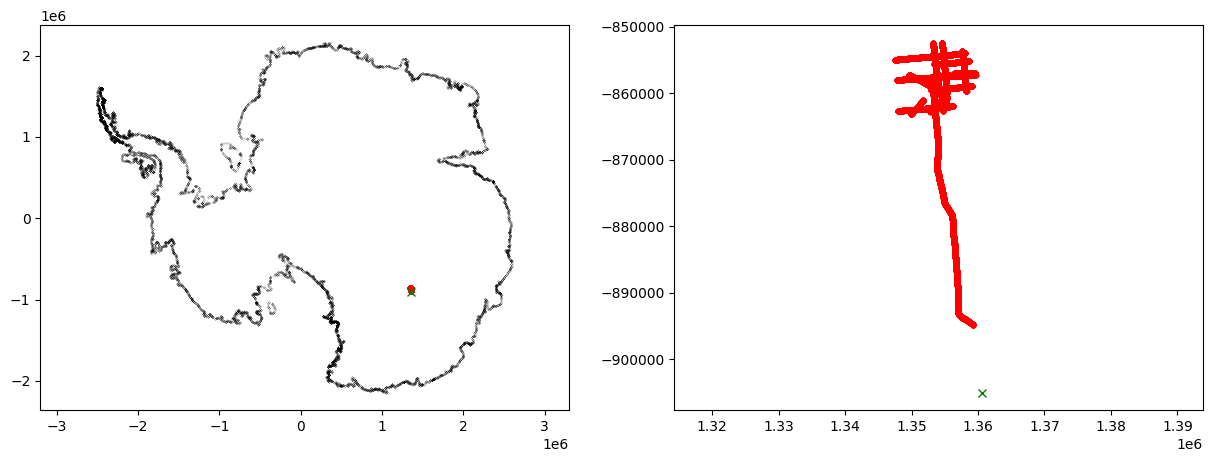

In [134]:
# Plot all survey groundtracks
fig = plt.figure(figsize=(15,5))
ax1, ax2 = fig.subplots(1,2)
ax1.plot(gl_xx, gl_yy, 'k.', markersize=0.2)

for ax in [ax1, ax2]:
    for line, data in ldc_data.items():
        ax.plot(data.easting, data.northing, 'r.')
    ax.plot(targetA_xx, targetA_yy, 'gx')
    ax.axis('equal')

fig.savefig('BAS_DomeC_DELORES_lines.png', dpi=300)


line: 2H25E-H25B, 5%/95%: -68.0 -> 67.0
line: 2H30E-H30B, 5%/95%: -162.25601959228516 -> 155.96942901611328
line: HRB8-RAID2, 5%/95%: -42.09001998901367 -> 39.78755340576171
line: 2V10E-2V11B, 5%/95%: -67.19426727294922 -> 66.1431655883789
line: BH39B-BH39E, 5%/95%: -78.0 -> 73.0
line: HRB7-HRB8, 5%/95%: -38.70634384155274 -> 38.276234436035175
line: HRA1-HRA2, 5%/95%: -39.526329040527344 -> 38.23970184326164
line: HRB1-HRB2, 5%/95%: -38.92048187255859 -> 38.38151550292966
line: H42B-2H42E, 5%/95%: -160.13501358032227 -> 153.80082321166992
line: 2V23B-2V23E, 5%/95%: -100.77332305908203 -> 102.34433898925778
line: RAID-2V11E, 5%/95%: -151.2349540710449 -> 143.88060302734362
line: DC-LDC-DIVIDE, 5%/95%: -130.06867599487305 -> 127.95462799072266
line: V03E-2V03B, 5%/95%: -160.02161865234373 -> 154.3398681640623
line: V18B-V18E, 5%/95%: -165.57383193969724 -> 158.6651695251464


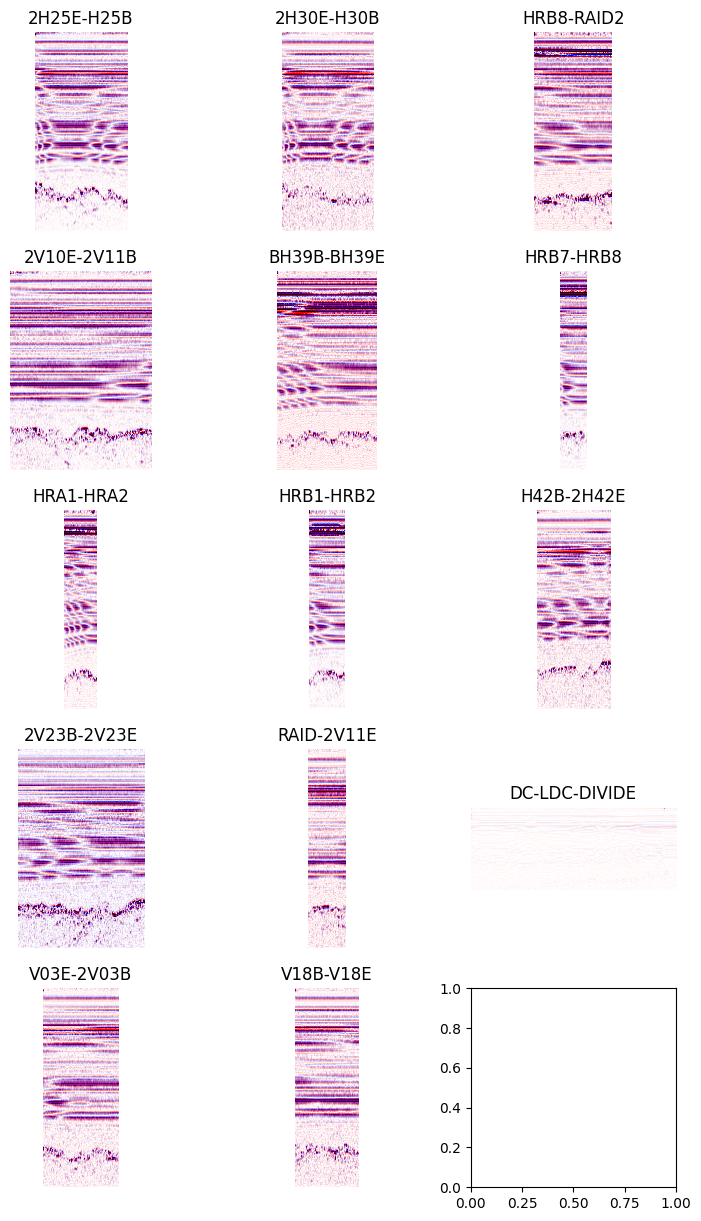

In [141]:
# And, next, plot all radargrams
# I'll clearly need to figure out a better way of plotting these; 
# I don't think they have enough contrast.  
# Ah! thus the seismic colorscale =)
num_radargrams = len(ldc_data)
ncols = 3
nrows = int(np.ceil(len(ldc_data) / ncols))

fig = plt.figure(figsize=(3*ncols, 3*nrows))
axs = fig.subplots(nrows, ncols)

for idx, (line, radardata) in enumerate(ldc_data.items()):
    col = idx % ncols
    row = int(np.floor(idx / ncols))
    data = radardata.data.transpose()
    p5 = np.percentile(data, 5)
    p95 = np.percentile(data, 95)
    print(f"line: {line}, 5%/95%: {p5} -> {p95}")
    axs[row][col].imshow(data, cmap='seismic', clim=[p5, p95])
    axs[row][col].axis('off')
    axs[row][col].set_title(line)
fig.savefig('BAS_DomeC_DELORES_radargrams.png', dpi=300)


In [126]:
nrows

5

In [80]:
def plot_delores_segy(filepath):
    fig = plt.figure()
    ax1, ax2 = fig.subplots(1,2)
    
    sf = segyio.open(filepath, ignore_geometry=True)
    num_traces = sf.tracecount
    num_samples = len(sf.samples)
    data = np.zeros((num_traces, num_samples))
    for idx, tr in enumerate(sf.trace):
        data[idx,:] = tr
    print(f"{np.min(data)}, {np.max(data)}")
    # It appears that these are in tenths-of-a-meter, PS71. But I'm not totally certain. 
    # I should probably check start/end of line using the CSV data
    xx = sf.attributes(segyio.TraceField.GroupX)[:]
    yy = sf.attributes(segyio.TraceField.GroupY)[:]

    ax1.imshow(data.transpose(), cmap='gray')
    ax2.plot(xx, yy, 'k.')

-800.0, 489.0
-1388.7607421875, 884.181884765625
-428.09130859375, 668.425537109375
-533.819091796875, 487.25537109375
-487.0, 590.0
-511.3193359375, 635.22802734375
-361.55517578125, 554.765625
-495.12158203125, 619.422119140625
-2071.468994140625, 1388.06396484375
-1799.996337890625, 1428.6025390625
-1226.51123046875, 797.294921875
-2626.526611328125, 3997.333740234375
-1459.692138671875, 957.719482421875
-1099.74951171875, 758.479248046875


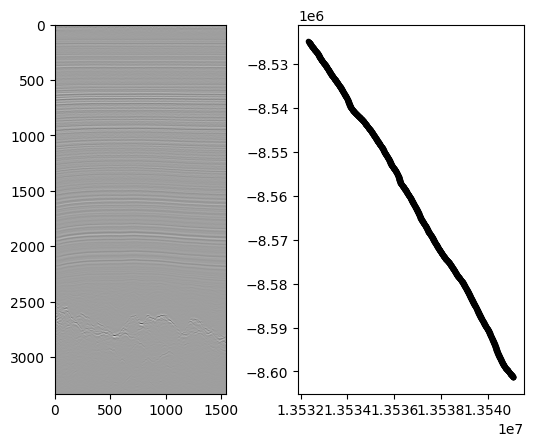

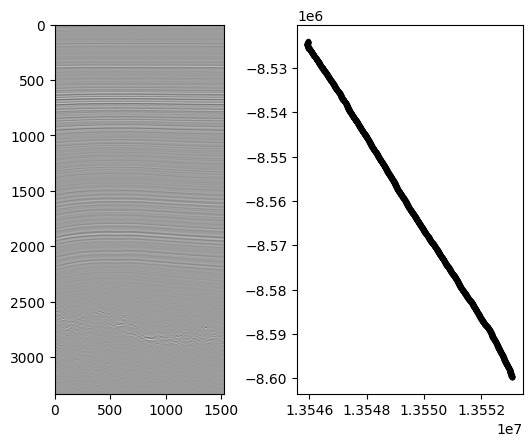

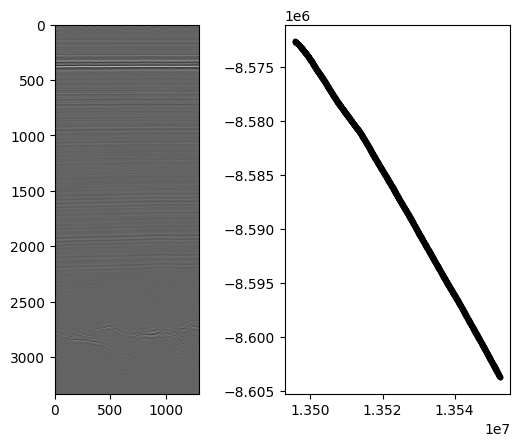

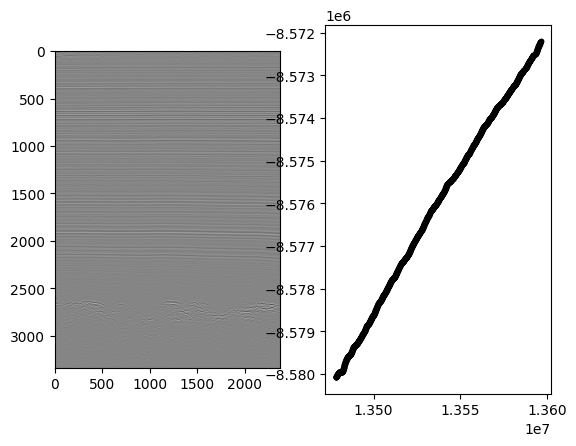

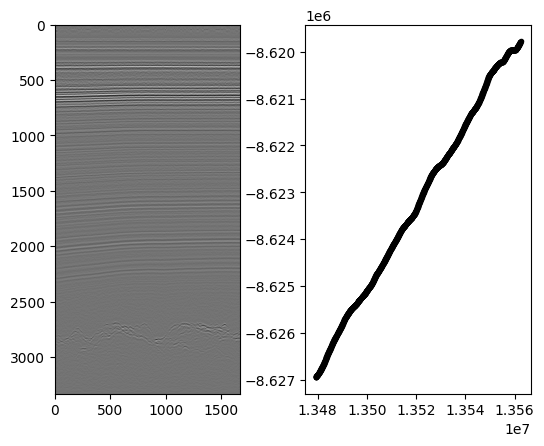

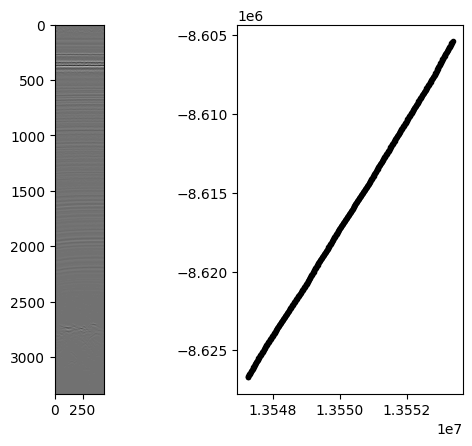

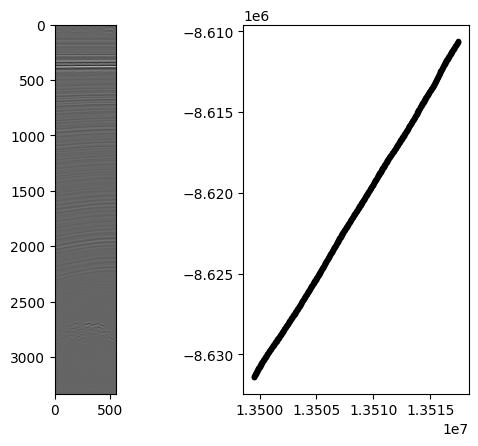

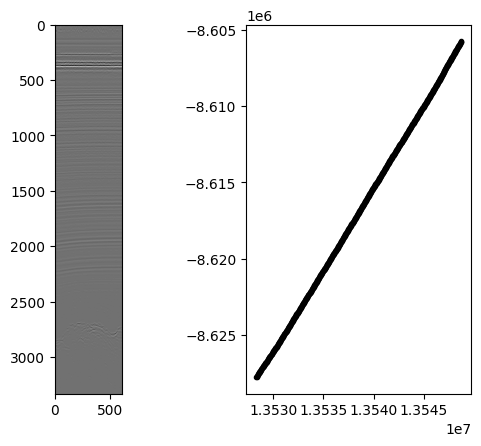

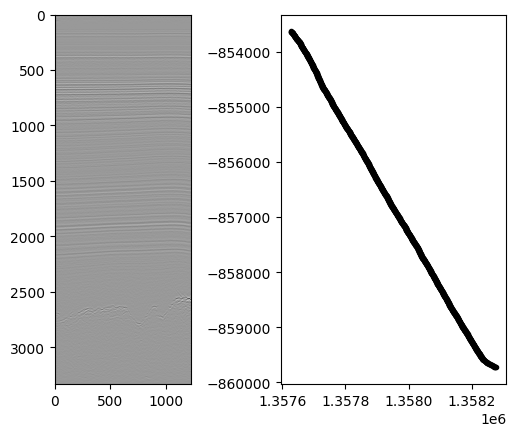

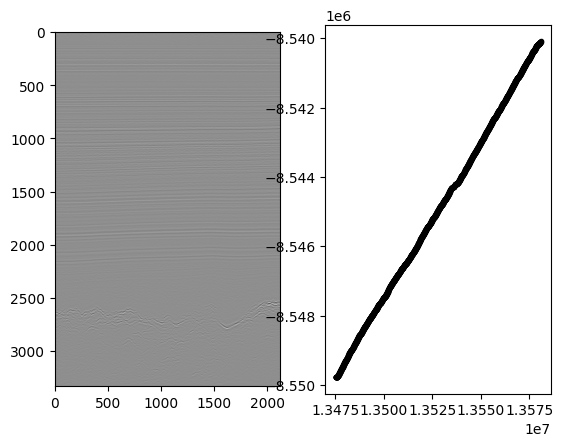

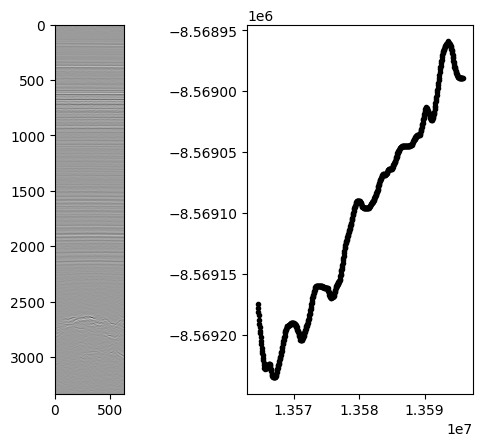

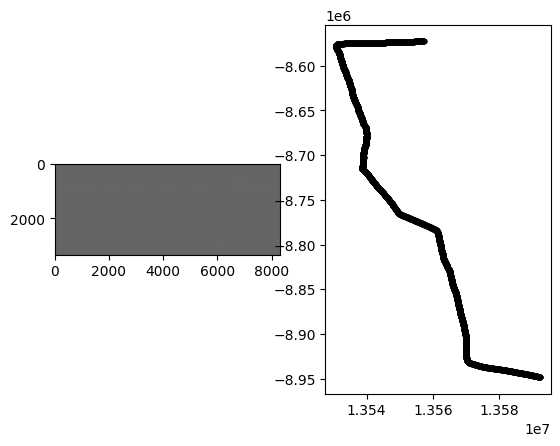

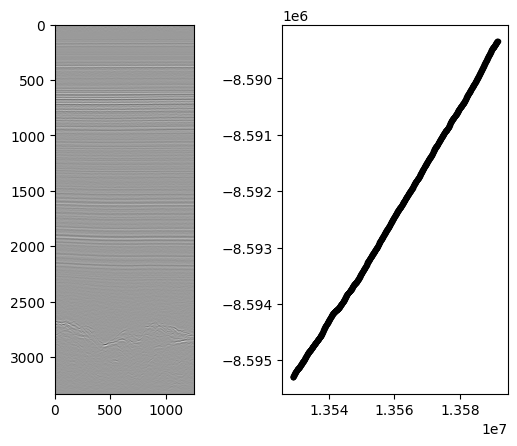

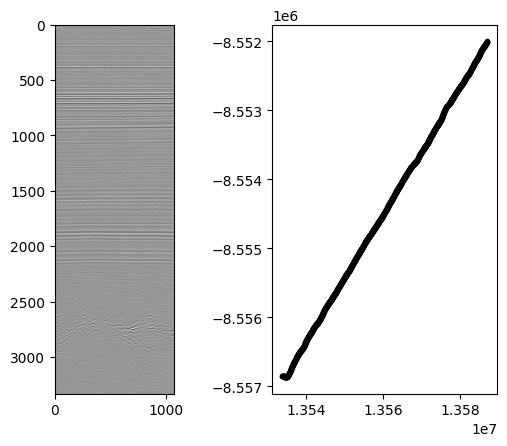

In [96]:
for ff in segy_files:
    plot_delores_segy(ff)

In [4]:
sf = segyio.open(filepath, ignore_geometry=True)

In [34]:
num_traces = sf.tracecount
num_samples = len(sf.samples)

In [39]:
data = np.zeros((num_traces, num_samples))
for idx, tr in enumerate(sf.trace):
    data[idx,:] = tr
print(f"{np.min(data)}, {np.max(data)}")

-800.0, 489.0


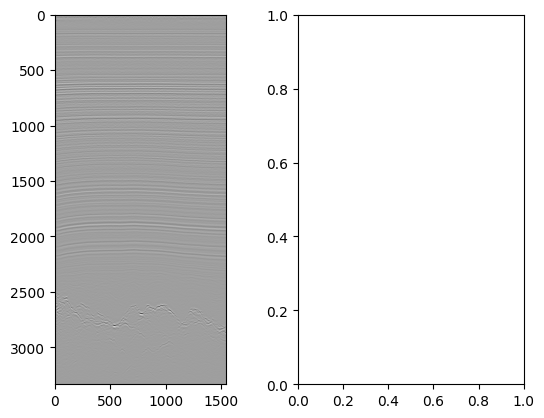

In [79]:
fig = plt.figure()
ax1, ax2 = fig.subplots(1,2)
ax1.imshow(data.transpose(), cmap='gray')

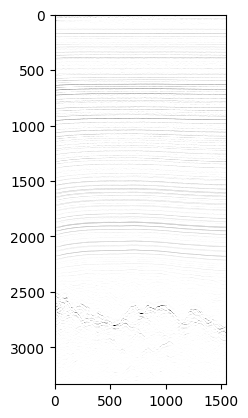

In [44]:
im = plt.imshow(data.transpose(), cmap='gray', clim=[-400, 0])

In [47]:
data[30, 10:100]

array([ 17.,  23.,  23.,  19.,  10.,  -1.,  -9., -12.,  -8.,   1.,  12.,
        19.,  18.,   9.,  -7., -26., -44., -56., -60., -58., -53., -47.,
       -43., -41., -40., -37., -29., -16.,   3.,  25.,  48.,  69.,  84.,
        92.,  93.,  88.,  80.,  68.,  56.,  44.,  32.,  20.,   7.,  -5.,
       -18., -29., -38., -45., -49., -51., -51., -48., -45., -40., -35.,
       -28., -21., -13.,  -6.,   1.,   7.,  12.,  14.,  14.,  12.,   9.,
         5.,   1.,  -1.,  -3.,  -4.,  -4.,  -2.,  -1.,   2.,   4.,   6.,
         8.,   9.,  10.,   9.,   8.,   6.,   4.,   2.,   1.,   2.,   4.,
         7.,   9.])

In [20]:
# Looks like these are probably in ns
sf.samples, len(sf.samples)

(array([0.0000e+00, 1.2000e+01, 2.4000e+01, ..., 3.9972e+04, 3.9984e+04,
        3.9996e+04]),
 3334)

In [52]:
# It appears that these are in tenths-of-a-meter, PS71. But I'm not totally certain. 
# I should probably check start/end of line using the CSV data
xx = sf.attributes(segyio.TraceField.GroupX)[:]
yy = sf.attributes(segyio.TraceField.GroupY)[:]

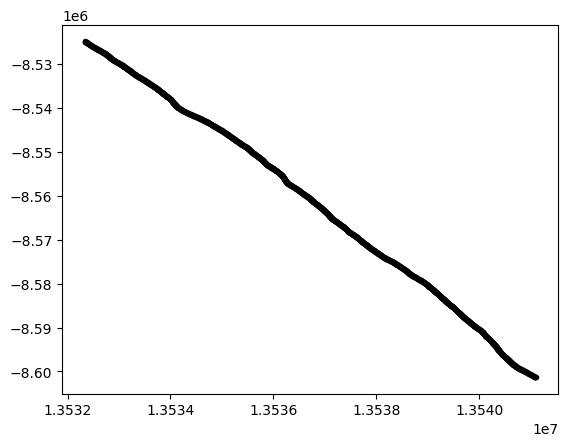

In [53]:
plt.plot(xx, yy, 'k.')

In [13]:
sf.header.segy

SegyFile('/Volumes/QIceRadar01/ANTARCTIC/BAS/LDC_2018/2H25E-H25B_proc2.SGY', 'r', iline = 189, xline = 193)

In [15]:
help(sf.attributes)

Help on method attributes in module segyio.segy:

attributes(field) method of segyio.segy.SegyFile instance
    File-wide attribute (header word) reading
    
    Lazily gather a single header word for every trace in the file. The
    array can be sliced, supports index lookup, and numpy-style
    list-of-indices.
    
    Parameters
    ----------
    
    field : int or segyio.TraceField
        field
    
    Returns
    -------
    
    attrs : Attributes
        A sliceable array_like of header words
    
    Notes
    -----
    
    .. versionadded:: 1.1



In [16]:
sf.trace

Trace(traces = 1543, samples = 3334)

In [11]:
help(sf.header.count)

Help on method count in module collections.abc:

count(value) method of segyio.trace.Header instance
    S.count(value) -> integer -- return number of occurrences of value

